In [ ]:
import tensorflow as tf
print("T4 GPU Available: ", tf.config.list_physical_devices('T4 GPU'))

T4 GPU Available:  []


In [ ]:
#อนุญาตการเข้าถึง google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  Preparing data

In [ ]:
#Importing required libraries

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np #
import pandas as pd

from keras import Sequential
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
# from keras import regularizers
from tensorflow.keras.models import Model


from keras.preprocessing.image import load_img


<ipython-input-2-08eb76533b0e>:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
import tensorflow as tf

# Check for GPU
print("T4 GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

# Check for CPU
print("CPU", "available" if tf.config.list_physical_devices("CPU") else "not available")


T4 GPU not available :(
CPU available


In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/data-science/miniproject/Training_set.csv')
labels.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [ ]:
labels.describe()

,filename,label
count,6499,6499
unique,6499,75
top,Image_1.jpg,MOURNING CLOAK
freq,1,131


<ipython-input-6-98bed238db3c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax0 = sns.countplot(y=labels['label'], order=labels['label'].value_counts().index, palette="pastel")


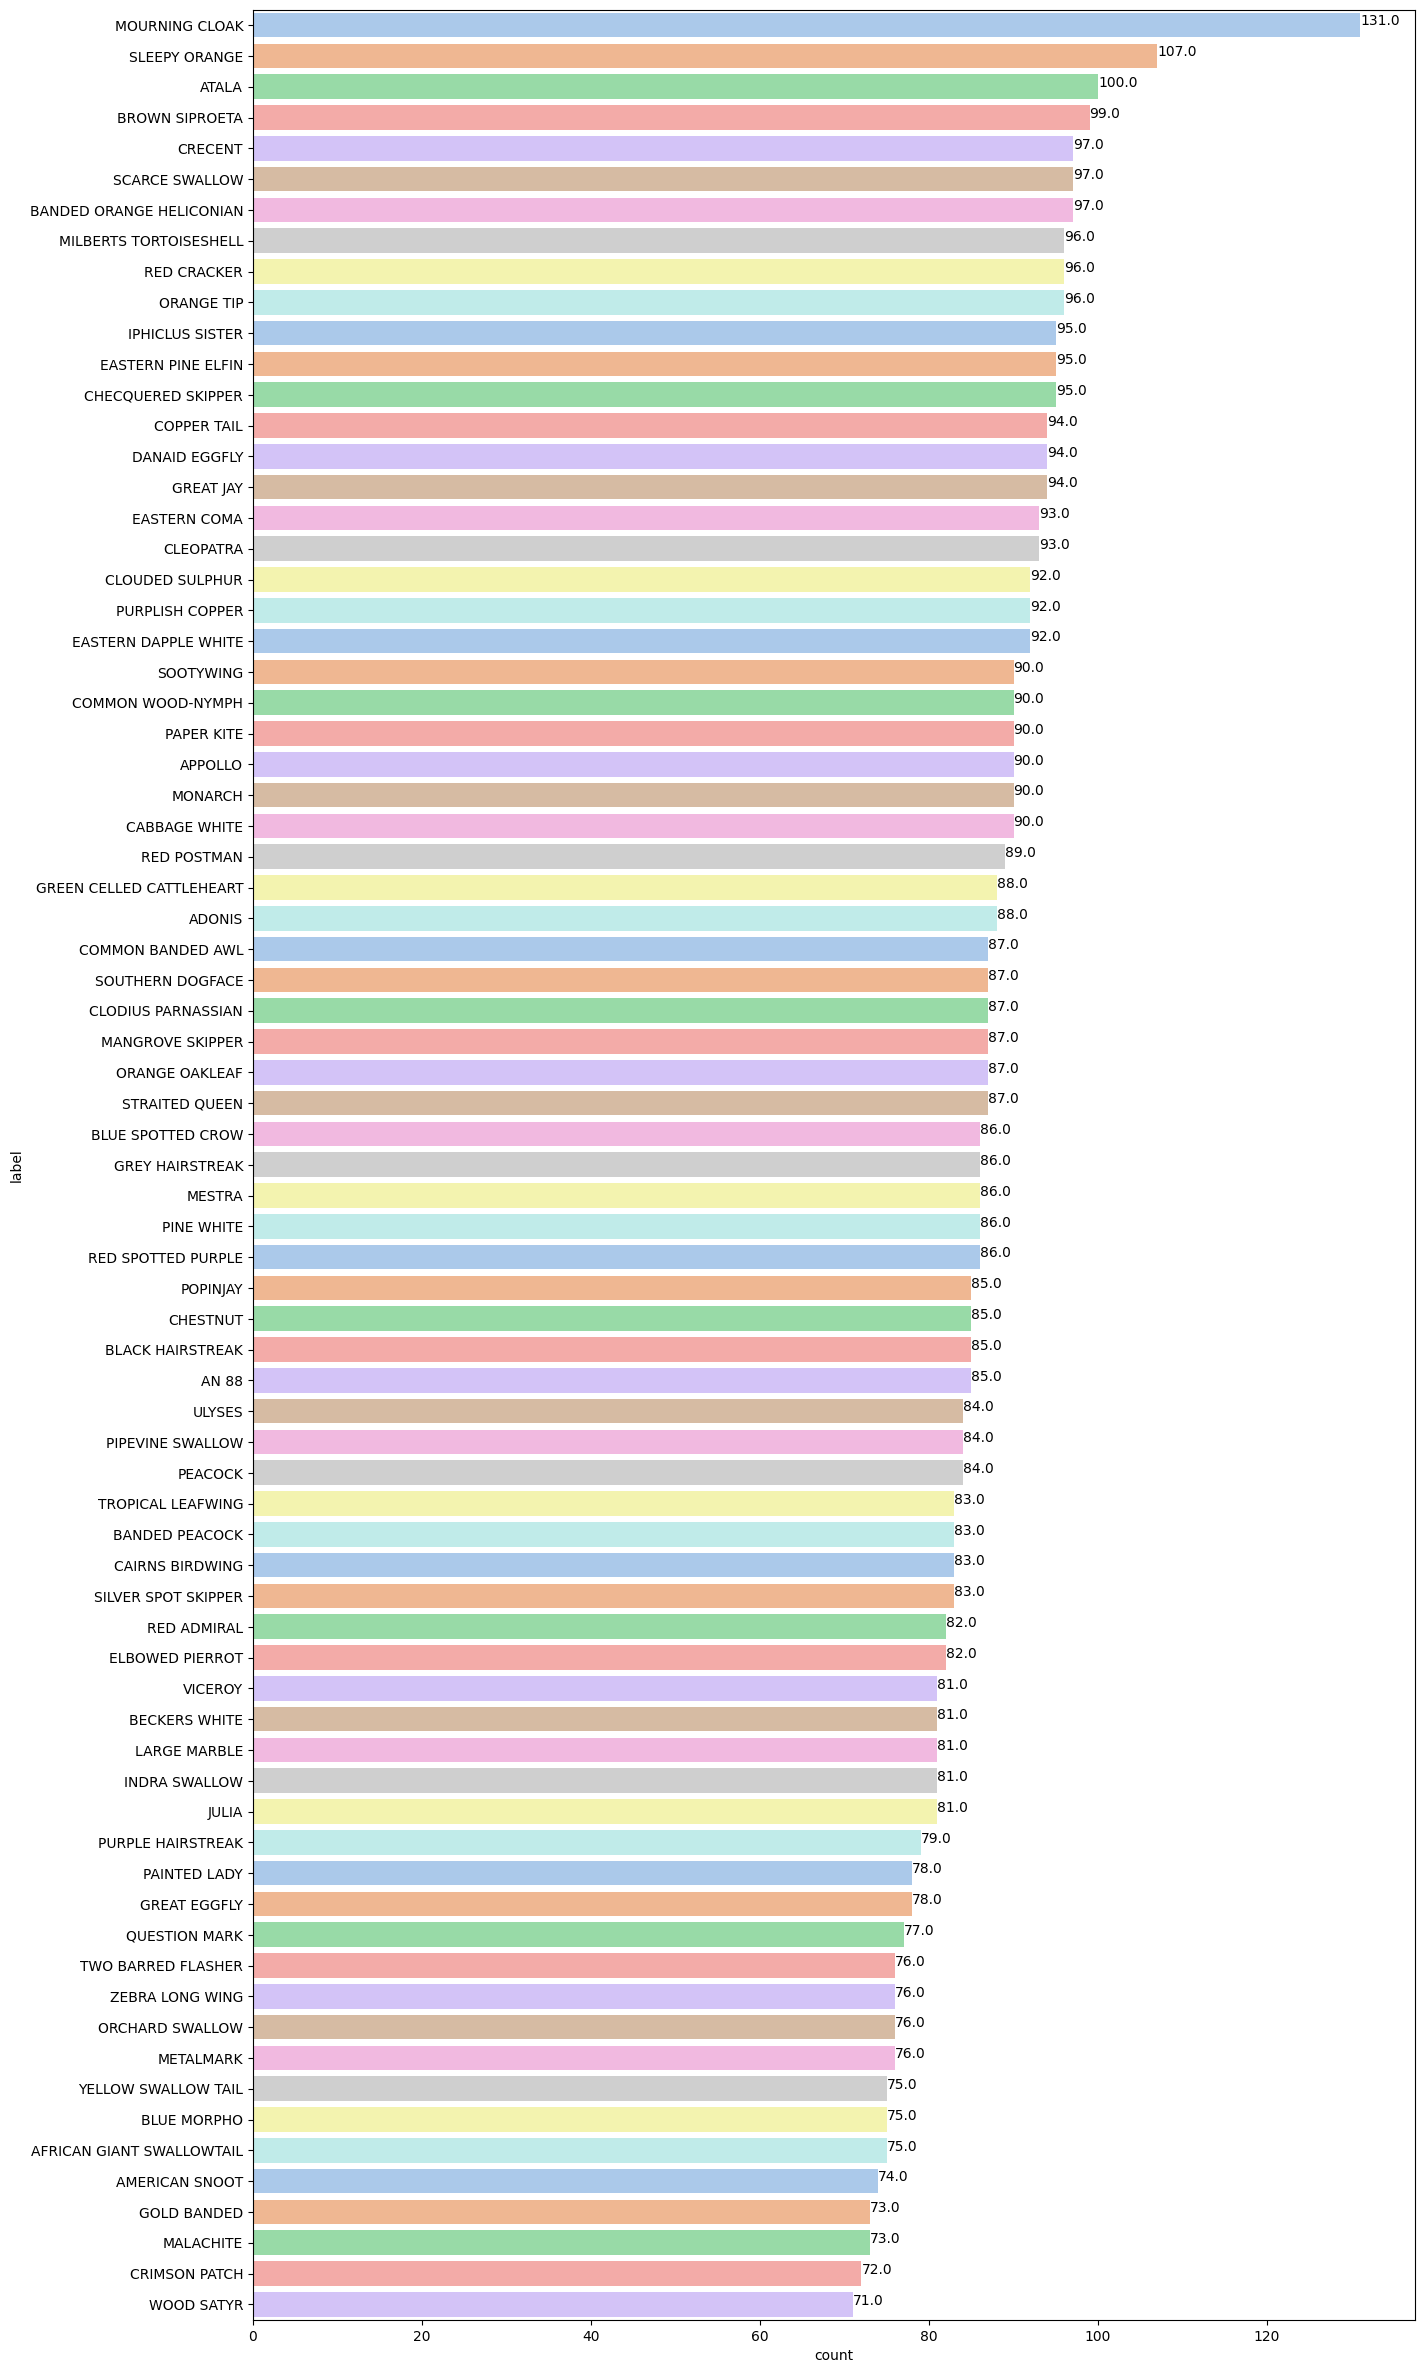

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def barw(ax):
    for p in ax.patches:
        val = p.get_width()  # height of the bar
        x = p.get_x() + p.get_width()  # x-position
        y = p.get_y() + p.get_height() / 2  # y-position
        ax.annotate(round(val, 2), (x, y))

# finding top dog brands
plt.figure(figsize=(15, 30))
ax0 = sns.countplot(y=labels['label'], order=labels['label'].value_counts().index, palette="pastel")
barw(ax0)
plt.show()


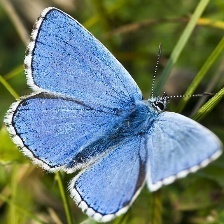

In [ ]:
# Lets check one image
from IPython.display import display, Image
Image("/content/drive/MyDrive/data-science/miniproject/train/Image_2.jpg")

In [ ]:
import os

# Assuming 'labels' is the dictionary containing filenames
num_files_in_directory = len(os.listdir('/content/drive/MyDrive/data-science/miniproject/train'))
num_actual_images = len(labels['filename'])

print("Number of files in directory:", num_files_in_directory)
print("Number of actual images:", num_actual_images)

if num_files_in_directory == num_actual_images:
    print('Number of files matches number of actual images!')
else:
    print('Number of files does not match number of actual images!!')


Number of files in directory: 6500
Number of actual images: 6499
Number of files does not match number of actual images!!


In [ ]:
#Create list of alphabetically sorted labels.
classes = sorted(list(set(labels['label'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))



#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 75


{'ADONIS': 0,
 'AFRICAN GIANT SWALLOWTAIL': 1,
 'AMERICAN SNOOT': 2,
 'AN 88': 3,
 'APPOLLO': 4,
 'ATALA': 5,
 'BANDED ORANGE HELICONIAN': 6,
 'BANDED PEACOCK': 7,
 'BECKERS WHITE': 8,
 'BLACK HAIRSTREAK': 9,
 'BLUE MORPHO': 10,
 'BLUE SPOTTED CROW': 11,
 'BROWN SIPROETA': 12,
 'CABBAGE WHITE': 13,
 'CAIRNS BIRDWING': 14,
 'CHECQUERED SKIPPER': 15,
 'CHESTNUT': 16,
 'CLEOPATRA': 17,
 'CLODIUS PARNASSIAN': 18,
 'CLOUDED SULPHUR': 19,
 'COMMON BANDED AWL': 20,
 'COMMON WOOD-NYMPH': 21,
 'COPPER TAIL': 22,
 'CRECENT': 23,
 'CRIMSON PATCH': 24,
 'DANAID EGGFLY': 25,
 'EASTERN COMA': 26,
 'EASTERN DAPPLE WHITE': 27,
 'EASTERN PINE ELFIN': 28,
 'ELBOWED PIERROT': 29,
 'GOLD BANDED': 30,
 'GREAT EGGFLY': 31,
 'GREAT JAY': 32,
 'GREEN CELLED CATTLEHEART': 33,
 'GREY HAIRSTREAK': 34,
 'INDRA SWALLOW': 35,
 'IPHICLUS SISTER': 36,
 'JULIA': 37,
 'LARGE MARBLE': 38,
 'MALACHITE': 39,
 'MANGROVE SKIPPER': 40,
 'MESTRA': 41,
 'METALMARK': 42,
 'MILBERTS TORTOISESHELL': 43,
 'MONARCH': 44,
 'MOURNING

In [ ]:
input_shape = (331,331,3)


def images_to_array(directory, label_dataframe, target_size = input_shape):

    image_labels = label_dataframe['label']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)

    for ix, image_name in enumerate(tqdm(label_dataframe['filename'].values)):
        img_dir = os.path.join(directory, image_name  )
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img

        butterfly_breed = image_labels[ix]
        y[ix] = class_to_num[butterfly_breed]

    y = to_categorical(y)

    return images,y



In [ ]:
images, y = images_to_array('/content/drive/MyDrive/data-science/miniproject/train', labels[:])

  0%|          | 0/6499 [00:00<?, ?it/s]

In [ ]:
images.shape,y.shape

((6499, 331, 331, 3), (6499, 75))

In [ ]:
images_reshaped = images.reshape(images.shape[0], -1)

In [ ]:
images_reshaped

array([[ 25,  43,  31, ...,  43,  69,  21],
       [146, 143,  92, ...,  95, 128,  41],
       [236, 232, 229, ..., 237, 233, 230],
       ...,
       [ 35,  62,  21, ...,  17,  41,   7],
       [236, 236, 234, ..., 205, 201, 192],
       [227, 228, 222, ...,  81, 114,  27]], dtype=uint8)

# Model NNL

In [ ]:
import time
t = time.time()

X,y = images_to_array('/content/drive/MyDrive/data-science/miniproject/train', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/6499 [00:00<?, ?it/s]

runtime in seconds: 188.81386876106262


In [ ]:
# np.where(y[5]==1)[0][0]

# lets check some dogs and their breeds
n=25

# setup the figure
plt.figure(figsize=(20,20))

for i in range(n):
#     print(i)
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32')) # .astype('int32') ---> as imshow() needs integer data to read the image


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images_to_array

target array

In [ ]:
import os
from tqdm import tqdm
from keras.preprocessing.image import load_img
from keras.utils import to_categorical

input_shape = (331, 331, 3)

def images_to_array(directory, label_dataframe, target_size=input_shape):

    image_labels = label_dataframe['label']

    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]], dtype=np.uint8)

    y = np.zeros([len(label_dataframe), 1], dtype=np.uint8)

    for ix, image_name in enumerate(tqdm(label_dataframe['filename'].values)):
        img_dir = os.path.join(directory, image_name)
        img = load_img(img_dir, target_size=target_size)

        images[ix] = img

        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]


    y = to_categorical(y)

    return images, y

# สร้าง NumPy arrays จากรูปภาพในไดเรกทอรีและป้ายชื่อ
X, y = images_to_array('/content/drive/MyDrive/data-science/miniproject/train', labels[:])


**์์Model** **NNL**

In [ ]:
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Hyperparameters
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

In [ ]:
#function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)

    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [ ]:
# Extract features using InceptionV3
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

204/204 [==============================] - 2026s 10s/step
Feature maps shape:  (6499, 2048)


In [ ]:
# Extract features using Xception
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

204/204 [==============================] - 3595s 18s/step
Feature maps shape:  (6499, 2048)


In [ ]:
# Extract features using InceptionResNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

204/204 [==============================] - 4807s 24s/step
Feature maps shape:  (6499, 1536)


In [ ]:
# Extract features using NASNetLarge
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

KeyboardInterrupt: 

In [ ]:
del X #to free up some ram memory
gc.collect()

In [ ]:
#Creating final featuremap by combining all extracted features

final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features], axis=-1)


# print('Final feature maps shape', final_features.shape)

In [ ]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features], axis=-1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential()
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes, activation='softmax'))

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)  # ใช้ Optimizer แบบเก่าของ TensorFlow
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model.
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr, EarlyStop])


Epoch 1/50
37/41 [==========================>...] - ETA: 0s - loss: 2.9139 - accuracy: 0.2802

41/41 [==============================] - 3s 13ms/step - loss: 2.8214 - accuracy: 0.3051 - val_loss: 1.7480 - val_accuracy: 0.6369 - lr: 0.0010
Epoch 2/50
38/41 [==========================>...] - ETA: 0s - loss: 1.4537 - accuracy: 0.6536

41/41 [==============================] - 0s 6ms/step - loss: 1.4352 - accuracy: 0.6586 - val_loss: 1.1998 - val_accuracy: 0.7477 - lr: 0.0010
Epoch 3/50
36/41 [=========================>....] - ETA: 0s - loss: 1.0321 - accuracy: 0.7565

41/41 [==============================] - 0s 7ms/step - loss: 1.0294 - accuracy: 0.7546 - val_loss: 0.9636 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 4/50
37/41 [==========================>...] - ETA: 0s - loss: 0.8252 - accuracy: 0.8093

41/41 [==============================] - 0s 7ms/step - loss: 0.8155 - accuracy: 0.8119 - val_loss: 0.8295 - val_accuracy: 0.8231 - lr: 0.0010
Epoch 5/50
36/41 [=========================>....] - ETA: 0s - loss: 0.6826 - accuracy: 0.8383

41/41 [==============================] - 0s 7ms/step - loss: 0.6765 - accuracy: 0.8396 - val_loss: 0.7484 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 6/50
37/41 [==========================>...] - ETA: 0s - loss: 0.5896 - accuracy: 0.8598

41/41 [==============================] - 0s 7ms/step - loss: 0.5915 - accuracy: 0.8592 - val_loss: 0.6870 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 7/50
38/41 [==========================>...] - ETA: 0s - loss: 0.5106 - accuracy: 0.8847

41/41 [==============================] - 0s 7ms/step - loss: 0.5102 - accuracy: 0.8842 - val_loss: 0.6556 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 8/50
39/41 [===========================>..] - ETA: 0s - loss: 0.4650 - accuracy: 0.8910

41/41 [==============================] - 0s 6ms/step - loss: 0.4626 - accuracy: 0.8915 - val_loss: 0.6138 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 9/50
37/41 [==========================>...] - ETA: 0s - loss: 0.4169 - accuracy: 0.9039

41/41 [==============================] - 0s 6ms/step - loss: 0.4198 - accuracy: 0.9027 - val_loss: 0.5803 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 10/50
37/41 [==========================>...] - ETA: 0s - loss: 0.3751 - accuracy: 0.9164

41/41 [==============================] - 0s 7ms/step - loss: 0.3778 - accuracy: 0.9150 - val_loss: 0.5637 - val_accuracy: 0.8615 - lr: 0.0010
Epoch 11/50
38/41 [==========================>...] - ETA: 0s - loss: 0.3406 - accuracy: 0.9219

41/41 [==============================] - 0s 7ms/step - loss: 0.3404 - accuracy: 0.9223 - val_loss: 0.5247 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 12/50
38/41 [==========================>...] - ETA: 0s - loss: 0.3245 - accuracy: 0.9256

41/41 [==============================] - 0s 6ms/step - loss: 0.3223 - accuracy: 0.9279 - val_loss: 0.5366 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 13/50
39/41 [===========================>..] - ETA: 0s - loss: 0.2938 - accuracy: 0.9319

41/41 [==============================] - 0s 6ms/step - loss: 0.2932 - accuracy: 0.9321 - val_loss: 0.5102 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 14/50
38/41 [==========================>...] - ETA: 0s - loss: 0.2719 - accuracy: 0.9406

41/41 [==============================] - 0s 7ms/step - loss: 0.2753 - accuracy: 0.9398 - val_loss: 0.4909 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 15/50
34/41 [=======================>......] - ETA: 0s - loss: 0.2554 - accuracy: 0.9453

41/41 [==============================] - 0s 7ms/step - loss: 0.2570 - accuracy: 0.9452 - val_loss: 0.4943 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 16/50
39/41 [===========================>..] - ETA: 0s - loss: 0.2462 - accuracy: 0.9457

41/41 [==============================] - 0s 8ms/step - loss: 0.2448 - accuracy: 0.9467 - val_loss: 0.4773 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 17/50
34/41 [=======================>......] - ETA: 0s - loss: 0.2229 - accuracy: 0.9506

41/41 [==============================] - 0s 9ms/step - loss: 0.2237 - accuracy: 0.9506 - val_loss: 0.4688 - val_accuracy: 0.8877 - lr: 0.0010
Epoch 18/50
36/41 [=========================>....] - ETA: 0s - loss: 0.2045 - accuracy: 0.9601

41/41 [==============================] - 0s 9ms/step - loss: 0.2076 - accuracy: 0.9581 - val_loss: 0.4587 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 19/50
41/41 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9586

41/41 [==============================] - 0s 8ms/step - loss: 0.1978 - accuracy: 0.9586 - val_loss: 0.4599 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 20/50
41/41 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9621

41/41 [==============================] - 0s 8ms/step - loss: 0.1897 - accuracy: 0.9621 - val_loss: 0.4571 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 21/50
38/41 [==========================>...] - ETA: 0s - loss: 0.1889 - accuracy: 0.9601

41/41 [==============================] - 0s 9ms/step - loss: 0.1851 - accuracy: 0.9617 - val_loss: 0.4543 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 22/50
37/41 [==========================>...] - ETA: 0s - loss: 0.1738 - accuracy: 0.9677

41/41 [==============================] - 0s 10ms/step - loss: 0.1728 - accuracy: 0.9681 - val_loss: 0.4537 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 23/50
37/41 [==========================>...] - ETA: 0s - loss: 0.1727 - accuracy: 0.9654

41/41 [==============================] - 0s 8ms/step - loss: 0.1718 - accuracy: 0.9656 - val_loss: 0.4466 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 24/50
39/41 [===========================>..] - ETA: 0s - loss: 0.1563 - accuracy: 0.9692

41/41 [==============================] - 0s 6ms/step - loss: 0.1572 - accuracy: 0.9692 - val_loss: 0.4487 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 25/50
37/41 [==========================>...] - ETA: 0s - loss: 0.1532 - accuracy: 0.9692

41/41 [==============================] - 0s 6ms/step - loss: 0.1542 - accuracy: 0.9683 - val_loss: 0.4345 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 26/50
40/41 [============================>.] - ETA: 0s - loss: 0.1431 - accuracy: 0.9688

41/41 [==============================] - 0s 6ms/step - loss: 0.1434 - accuracy: 0.9685 - val_loss: 0.4466 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 27/50
36/41 [=========================>....] - ETA: 0s - loss: 0.1380 - accuracy: 0.9729

41/41 [==============================] - 0s 7ms/step - loss: 0.1394 - accuracy: 0.9719 - val_loss: 0.4296 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 28/50
38/41 [==========================>...] - ETA: 0s - loss: 0.1302 - accuracy: 0.9749

41/41 [==============================] - 0s 7ms/step - loss: 0.1308 - accuracy: 0.9748 - val_loss: 0.4368 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 29/50
37/41 [==========================>...] - ETA: 0s - loss: 0.1259 - accuracy: 0.9728

41/41 [==============================] - 0s 7ms/step - loss: 0.1242 - accuracy: 0.9742 - val_loss: 0.4290 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 30/50
36/41 [=========================>....] - ETA: 0s - loss: 0.1243 - accuracy: 0.9750

41/41 [==============================] - 0s 7ms/step - loss: 0.1262 - accuracy: 0.9731 - val_loss: 0.4367 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 31/50
31/41 [=====================>........] - ETA: 0s - loss: 0.1156 - accuracy: 0.9766

41/41 [==============================] - 0s 7ms/step - loss: 0.1178 - accuracy: 0.9760 - val_loss: 0.4260 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 32/50
38/41 [==========================>...] - ETA: 0s - loss: 0.1092 - accuracy: 0.9780

41/41 [==============================] - 0s 6ms/step - loss: 0.1088 - accuracy: 0.9783 - val_loss: 0.4292 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 33/50
39/41 [===========================>..] - ETA: 0s - loss: 0.1081 - accuracy: 0.9792

41/41 [==============================] - 0s 6ms/step - loss: 0.1079 - accuracy: 0.9794 - val_loss: 0.4378 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 34/50
38/41 [==========================>...] - ETA: 0s - loss: 0.1092 - accuracy: 0.9755

41/41 [==============================] - 0s 6ms/step - loss: 0.1095 - accuracy: 0.9758 - val_loss: 0.4216 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 35/50
38/41 [==========================>...] - ETA: 0s - loss: 0.1066 - accuracy: 0.9807

41/41 [==============================] - 0s 6ms/step - loss: 0.1046 - accuracy: 0.9815 - val_loss: 0.4262 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 36/50
37/41 [==========================>...] - ETA: 0s - loss: 0.0991 - accuracy: 0.9795

41/41 [==============================] - 0s 7ms/step - loss: 0.0994 - accuracy: 0.9798 - val_loss: 0.4180 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 37/50
36/41 [=========================>....] - ETA: 0s - loss: 0.0940 - accuracy: 0.9842

41/41 [==============================] - 0s 7ms/step - loss: 0.0957 - accuracy: 0.9837 - val_loss: 0.4223 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 38/50
37/41 [==========================>...] - ETA: 0s - loss: 0.0920 - accuracy: 0.9823

41/41 [==============================] - 0s 6ms/step - loss: 0.0934 - accuracy: 0.9812 - val_loss: 0.4273 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 39/50
37/41 [==========================>...] - ETA: 0s - loss: 0.0887 - accuracy: 0.9829

41/41 [==============================] - 0s 6ms/step - loss: 0.0893 - accuracy: 0.9829 - val_loss: 0.4248 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 40/50
38/41 [==========================>...] - ETA: 0s - loss: 0.0879 - accuracy: 0.9829

41/41 [==============================] - 0s 6ms/step - loss: 0.0886 - accuracy: 0.9833 - val_loss: 0.4169 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 41/50
39/41 [===========================>..] - ETA: 0s - loss: 0.0860 - accuracy: 0.9836

41/41 [==============================] - 0s 6ms/step - loss: 0.0865 - accuracy: 0.9831 - val_loss: 0.4193 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 42/50
38/41 [==========================>...] - ETA: 0s - loss: 0.0866 - accuracy: 0.9827

41/41 [==============================] - 0s 6ms/step - loss: 0.0862 - accuracy: 0.9831 - val_loss: 0.4265 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 43/50
39/41 [===========================>..] - ETA: 0s - loss: 0.0794 - accuracy: 0.9854

41/41 [==============================] - 0s 6ms/step - loss: 0.0794 - accuracy: 0.9854 - val_loss: 0.4188 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 44/50
37/41 [==========================>...] - ETA: 0s - loss: 0.0817 - accuracy: 0.9812

41/41 [==============================] - 0s 6ms/step - loss: 0.0815 - accuracy: 0.9817 - val_loss: 0.4224 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 45/50
36/41 [=========================>....] - ETA: 0s - loss: 0.0719 - accuracy: 0.9872

41/41 [==============================] - 0s 6ms/step - loss: 0.0726 - accuracy: 0.9871 - val_loss: 0.4313 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 46/50
37/41 [==========================>...] - ETA: 0s - loss: 0.0699 - accuracy: 0.9867

41/41 [==============================] - 0s 6ms/step - loss: 0.0718 - accuracy: 0.9869 - val_loss: 0.4188 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 47/50
36/41 [=========================>....] - ETA: 0s - loss: 0.0739 - accuracy: 0.9857

41/41 [==============================] - 0s 7ms/step - loss: 0.0755 - accuracy: 0.9854 - val_loss: 0.4219 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 48/50
38/41 [==========================>...] - ETA: 0s - loss: 0.0665 - accuracy: 0.9899

41/41 [==============================] - 0s 6ms/step - loss: 0.0679 - accuracy: 0.9892 - val_loss: 0.4191 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 49/50
37/41 [==========================>...] - ETA: 0s - loss: 0.0659 - accuracy: 0.9903

41/41 [==============================] - 0s 7ms/step - loss: 0.0659 - accuracy: 0.9908 - val_loss: 0.4303 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 50/50
36/41 [=========================>....] - ETA: 0s - loss: 0.0690 - accuracy: 0.9863

41/41 [==============================] - 0s 6ms/step - loss: 0.0702 - accuracy: 0.9863 - val_loss: 0.4267 - val_accuracy: 0.8946 - lr: 0.0010


In [ ]:
#deleting to free up ram memory

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

1374

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img
from tqdm import tqdm

def images_to_array_test(test_path, img_size=(331, 331, 3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)

    for ix, img_dir in enumerate(tqdm(test_filenames)):
        #print("Processing image:", img_dir)
        if os.path.isfile(img_dir):  # ตรวจสอบว่าไฟล์มีอยู่จริงหรือไม่
            img = load_img(img_dir, target_size=img_size)
            images[ix] = img
            del img
        else:
            print("File not found:", img_dir)

    print('Output Data Size:', images.shape)
    return images

test_data = images_to_array_test('/content/drive/MyDrive/data-science/miniproject/test/', img_size)


100%|██████████| 2786/2786 [01:20<00:00, 34.80it/s] 

Output Data Size: (2786, 331, 331, 3)


In [16]:
#Extract test data features.
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)

    print('Final feature maps shape', final_features.shape)

    #deleting to free up ram memory
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()


    return final_features

test_features = extact_features(test_data)

In [ ]:
#Free up some space.
del test_data
gc.collect()

17

In [ ]:
#Predict test labels given test data features.

pred = model.predict(test_features)

88/88 [==============================] - 0s 2ms/step


In [ ]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}")
print(f"Sum: {np.sum(pred[0])}")
print(f"Max index: {np.argmax(pred[0])}")
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

[3.4808735e-08 5.7530934e-07 1.4269140e-06 3.3034368e-07 1.6920768e-04
 5.5524856e-09 8.2393899e-06 4.8711154e-06 4.7149413e-05 3.4596594e-12
 1.8528684e-06 2.1924943e-07 1.0889092e-07 2.6099919e-10 5.4571547e-06
 3.6926679e-06 8.8688541e-09 4.8655457e-09 9.9571735e-01 7.8076023e-10
 3.0989708e-07 2.4506790e-09 1.3083331e-07 1.2270738e-06 6.3115060e-08
 1.4032853e-06 4.6995515e-07 3.6719316e-04 1.8963004e-09 1.8110899e-06
 4.8442439e-07 4.5540323e-09 3.4007022e-05 1.7465201e-06 3.3584739e-11
 5.8144565e-07 1.5151232e-07 1.9096049e-07 2.1697376e-03 1.2150615e-05
 8.2088286e-07 6.6304463e-05 3.3314916e-06 6.8306292e-08 1.4056343e-14
 6.4253638e-09 1.3209891e-08 2.0992388e-04 8.0570608e-05 5.9197799e-07
 7.6350580e-06 8.1603758e-08 5.7590473e-04 1.0459421e-07 1.2956855e-07
 3.9524179e-09 7.2706140e-11 3.5074454e-08 7.1266783e-07 2.2758451e-05
 5.2892733e-07 2.4848537e-10 4.5478353e-04 2.0625336e-07 5.2120175e-10
 9.7024305e-08 3.3312504e-06 1.2292949e-09 2.7770068e-07 9.3517656e-07
 6.985

In [ ]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["filename"] + list(classes))
preds_df.head()

,filename,ADONIS,AFRICAN GIANT SWALLOWTAIL,AMERICAN SNOOT,AN 88,APPOLLO,ATALA,BANDED ORANGE HELICONIAN,BANDED PEACOCK,BECKERS WHITE,...,SOOTYWING,SOUTHERN DOGFACE,STRAITED QUEEN,TROPICAL LEAFWING,TWO BARRED FLASHER,ULYSES,VICEROY,WOOD SATYR,YELLOW SWALLOW TAIL,ZEBRA LONG WING


In [ ]:
# Append test image ID's to predictions DataFrame
test_path = "/content/drive/MyDrive/data-science/miniproject/test"
preds_df["filename"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,filename,ADONIS,AFRICAN GIANT SWALLOWTAIL,AMERICAN SNOOT,AN 88,APPOLLO,ATALA,BANDED ORANGE HELICONIAN,BANDED PEACOCK,BECKERS WHITE,...,SOOTYWING,SOUTHERN DOGFACE,STRAITED QUEEN,TROPICAL LEAFWING,TWO BARRED FLASHER,ULYSES,VICEROY,WOOD SATYR,YELLOW SWALLOW TAIL,ZEBRA LONG WING
0,Image_2579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Image_2612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Image_258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Image_2586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Image_2597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ระบุพาธสำหรับโฟลเดอร์ที่ต้องการบันทึกไฟล์
output_folder_path = '/content/drive/MyDrive/data-science/miniproject'

# บันทึกไฟล์ 'submission.csv' ไปยังโฟลเดอร์ที่กำหนด
preds_df.to_csv(output_folder_path + 'submission.csv', index=None)

# แสดงข้อมูลหัวตารางของไฟล์ที่บันทึก
preds_df.head()


,filename,ADONIS,AFRICAN GIANT SWALLOWTAIL,AMERICAN SNOOT,AN 88,APPOLLO,ATALA,BANDED ORANGE HELICONIAN,BANDED PEACOCK,BECKERS WHITE,...,SOOTYWING,SOUTHERN DOGFACE,STRAITED QUEEN,TROPICAL LEAFWING,TWO BARRED FLASHER,ULYSES,VICEROY,WOOD SATYR,YELLOW SWALLOW TAIL,ZEBRA LONG WING
0,Image_2579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Image_2612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Image_258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Image_2586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Image_2597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Testing with custom input

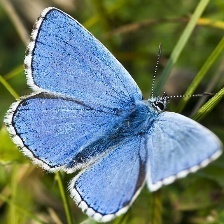

In [ ]:
#Custom input

Image('/content/drive/MyDrive/data-science/miniproject/train/Image_2.jpg')

In [ ]:
#reading the image and converting it into an np array

img_g = load_img('/content/drive/MyDrive/data-science/miniproject/train/Image_2.jpg',target_size = img_size)
img_g = np.expand_dims(img_g, axis=0) # as we trained our model in (row, img_height, img_width, img_rgb) format, np.expand_dims convert the image into this format
# img_g

In [ ]:
img_g.shape

(1, 331, 331, 3)

In [ ]:
# #Predict test labels given test data features.
test_features = extact_features(img_g)
predg = model.predict(test_features)
print(f"Predicted label: {classes[np.argmax(predg[0])]}")
print(f"Probability of prediction): {round(np.max(predg[0])) * 100} %")

1/1 [==============================] - 6s 6s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 4s 4s/step
Feature maps shape:  (1, 2048)
1/1 [==============================] - 8s 8s/step
Feature maps shape:  (1, 4032)


1/1 [==============================] - 5s 5s/step
Feature maps shape:  (1, 1536)
Final feature maps shape (1, 9664)
1/1 [==============================] - 0s 56ms/step
Predicted label: ADONIS
Probability of prediction): 100 %


# Train Test Split

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model K-NN

In [ ]:
from sklearn.model_selection import train_test_split

# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)


print("ขนาดของ X_train:", X_train.shape)
print("ขนาดของ X_test:", X_test.shape)
print("ขนาดของ y_train:", y_train.shape)
print("ขนาดของ y_test:", y_test.shape)

ขนาดของ X_train: (5199, 331, 331, 3)
ขนาดของ X_test: (1300, 331, 331, 3)
ขนาดของ y_train: (5199, 75)
ขนาดของ y_test: (1300, 75)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# สร้างและฝึกโมเดล k-NN
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train.reshape(len(X_train), -1), y_train)

In [ ]:
# ทำนายผลลัพธ์ของชุดทดสอบ
#y_pred = knn_model.predict(X_test.reshape(X_test.shape[0], -1))

y_pred = model.predict(X_test)

In [ ]:
import numpy as np

# เลือกคลาสที่มีความน่าจะเป็นสูงสุดจากการทำนาย
y_test_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)

# คำนวณ confusion matrix
cm = confusion_matrix(y_test_single, y_pred_single)
print(cm)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = plt.subplot()
plt.rcParams['figure.fifsize'] = 20,20
sns.heatmap(cm.annot=true, ax=ax, cmap="YIGnBu")

y = rang(0,40)
ax.set_xlabel("predicted labels")
ax.set_ylabel("actual labels")
ax.set_title("Confution matrix")

In [ ]:
from sklearn.metrics import accuracy_score


print("Accuracy: %.2f%"(accuracy_score(y_test, y_pred)*100))


# Train Model SVM

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')  # สร้างโมเดล SVM โดยใช้ kernel เป็นเส้นตรง (linear)
svm_model = SVC(kernel='poly')
svm_model = SVC(kernel='rbf')



svm_model.fit(X_train, y_train)


In [ ]:
y_pred = svm_model.predict(X_test)

Test pre

In [ ]:
from sklearn.metrics import accuracy_score

prediction = svm_model.predict(X_test)
accuracy_score(prediction,y_test)

In [ ]:
print("Precision:",precision_score(y_test, y_pred,average='micro'))
print("Recall :",recall_score_score(y_test, y_pred,average='micro'))
print("f1-score:",f1_score(y_test, y_pred,average='micro'))

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np



cm = confusion_matrix(y_test, y_pred)
print(cm)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# เลือกคลาสที่มีความน่าจะเป็นสูงสุดจากการทำนาย
y_test_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)

# คำนวณ confusion matrix
cm = confusion_matrix(y_test_single, y_pred_single)
print(cm)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = plt.subplot()
plt.rcParams['figure.fifsize'] = 20,20
sns.heatmap(cm.annot=true, ax=ax, cmap="YIGnBu")

y = rang(0,40)
ax.set_xlabel("predicted labels")
ax.set_ylabel("actual labels")
ax.set_title("Confution matrix")
